In [3]:
import MDAnalysis
import numpy as np
import nglview as nv
import matplotlib.pyplot as plt
print("Using MDAnalysis version", MDAnalysis.__version__)
print("Using NGLView version", nv.__version__)

/u/mk/ptch0465/softwaresrc/anaconda3/envs/test/lib/python3.9/site-packages/MDAnalysis/coordinates/chemfiles.py:108: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  MIN_CHEMFILES_VERSION = LooseVersion("0.9")


Using MDAnalysis version 2.0.0
Using NGLView version 3.0.3


In [4]:
#load a trajectory
u = MDAnalysis.Universe('final/C36dT.tpr','final/C36dT.xtc')
len(u.trajectory)

200874

In [7]:
v = nv.show_mdanalysis(u)
system = v.component_0
system.clear()
v.camera='orthographic'
v.center()
v.add_unitcell()
v.parameters = {"fogNear": 20}
sel=u.select_atoms('all')
system.add_licorice(selection = sel.atoms.indices)

In [8]:
v.display()

NGLWidget(max_frame=200873)

In [9]:
# radius of gyration
sel=u.select_atoms('all')
Rgs=[]
skipframes= 10000 #skip 100ns
for ts in u.trajectory[skipframes::]:
    
    coordinates = sel.atoms.positions
    center = np.sum(coordinates,axis=0)/len(coordinates)
    
    # get squared distance from center
    ri = np.linalg.norm(coordinates-center,axis=1) #0.852 oxdna conversion factor?
    # sum the unweighted positions
    sq = np.sum(ri*ri)/len(coordinates)

    Rgs.append(np.sqrt(sq))

In [10]:
#end to end distance
sel1=u.select_atoms('resindex 0')
sel2=u.select_atoms('resindex 29')
Rs=[]

for ts in u.trajectory[skipframes::]:

    coordinates1 = sel1.atoms.positions 
    coordinates2 = sel2.atoms.positions 
    center1 = np.sum(coordinates1,axis=0)/len(coordinates1)
    center2 = np.sum(coordinates2,axis=0)/len(coordinates2)
    Rs.append(np.linalg.norm(center1-center2))


In [11]:
import pandas as pd
df = pd.DataFrame({'x' : Rgs, 'y' : Rs})

/u/mk/ptch0465/softwaresrc/anaconda3/envs/test/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


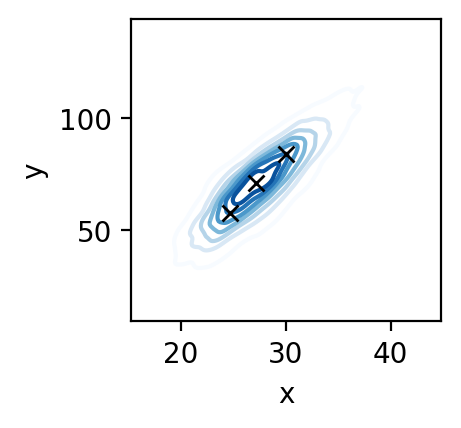

In [23]:
fig, ax = plt.subplots(figsize=(2, 2),dpi=200)
import seaborn as sns
ax = sns.kdeplot(df.x, df.y, cmap='Blues',levels=8) #cmap="viridis"


for path in ax.collections[-2].get_paths():
    x1, y1 = path.vertices.mean(axis=0);
    
innerx1 = ax.collections[-3].get_paths()[0].vertices[:,0] #inner path x coords
innery1 = ax.collections[-3].get_paths()[0].vertices[:,1]
    
ax.plot(x1, y1, "x",color='black')
ax.plot(innerx1[np.argmin(innery1)], innery1[np.argmin(innery1)], "x",color='black')
ax.plot(innerx1[np.argmax(innery1)], innery1[np.argmax(innery1)], "x",color='black')

In [220]:
def find_nearest2(array, value, array2, value2):
    array = np.asarray(array)
    array2 = np.asarray(array2)
    idx = (np.abs(array - value)+np.abs(array2 - value2)).argmin()
    return idx

In [260]:
frame = find_nearest2(Rgs,x1,Rs,y1) #find a frame of the trajectory with a given Rg, R
frame

200591

In [262]:
myRg=np.round(Rgs[frame],2)
myR=np.round(Rs[frame],2)

In [265]:
#pqr writer
import pytim
from pytim.datafiles import *
from MDAnalysis import transformations as trans
charmm = pytim_data.vdwradii(CHARMM36_TOP) 
interface = pytim.ITIM(u, radii_dict = charmm)
u.trajectory[frame+skipframes] # frames discarded remember!

radii = dict() #make dictionary from gmx .itp
#with open('ffamberbsc1.ff') as f:
with open('ffcharmm36.nonbonded.itp') as f:
#with open('hbcufix.itp') as f:
#with open('ffDES-AMBER.nonbonded.itp') as f:
#with open('DES_RNA.itp') as f:
    for line in f:
        data = (line.split(";")[0]).split()
        atom = data[0]
        radii[atom] = 0.5 * np.float(data[5]) *(2**(1/6)) #vdw radii, same as pdb2pqr
        
radii_array = np.zeros(len(u.atoms))
for i in range(len(u.atoms)):
    radii_array[i]=radii[u.atoms.types[i]] 
    
radii_array = radii_array*10 #convert to angstrom
        
hydrogens=u.select_atoms('mass 1.008').atoms.indices
heavyatoms=np.setdiff1d(u.atoms.indices,u.select_atoms('mass 1.008').atoms.indices) #indices

for j in heavyatoms:
    radii_array[j] = radii_array[j] + 2 # puff out, Ali w1.4
    
u.atoms.radii=radii_array #convert to angstrom

workflow = [trans.unwrap(u.atoms)]
u.trajectory.add_transformations(*workflow)

pa = u.atoms.principal_axes()
u.atoms.align_principal_axis(2, [1,0,0])

#Patoms=u.select_atoms('name P').atoms.indices #DES RNA only
#u.atoms[Patoms].charges= u.atoms[Patoms].charges -0.1
    
u.atoms[0].charge=u.atoms[0].charge -1
u.atoms[-1].charge=u.atoms[-1].charge -1 #terminal charges
    
a = MDAnalysis.coordinates.PQR.PQRWriter('C360Rg{}_R{}'.format(myRg,myR))

a.write(u)

/tmp/ipykernel_238276/3119592392.py:18: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  radii[atom] = 0.5 * np.float(data[5]) *(2**(1/6)) #vdw radii, same as pdb2pqr
/u/mk/ptch0465/softwaresrc/anaconda3/envs/test/lib/python3.9/site-packages/MDAnalysis/core/selection.py:907: SelectionWarning: Using float equality to select atoms is not recommended because of inherent limitations in representing numbers on computers (see https://docs.python.org/3.8/tutorial/floatingpoint.html for more). Instead, we recommend using a range to select, e.g. 'mass 0.008000000000000007 to 2.008'. If you still want to compare floats, use the `atol` and `rtol` keywords to modify the tolera

In [16]:
# orientational correlation analysis
backbone=u.select_atoms("name P")
n = len(backbone) #number of atoms formed to make chain of vectors

bs = []
for i in range(n-1):
    b = backbone.atoms.positions[i+1] - backbone.atoms.positions[i]
    bs.append(np.linalg.norm(b))

lb = np.mean(bs) #mean bond length for chain of vectors

results = np.zeros(n - 1, dtype=np.float32)

skipframes=10000

for step in u.trajectory[skipframes::]:
    # Vector from each atom to next
    vecs = backbone.positions[1:] - backbone.positions[:-1]
    #bcs.append(np.linalg.norm(backbone.positions[1:] - backbone.positions[:-1],axis=1))
    # Normalized to unit vectors
    vecs /= np.sqrt((vecs * vecs).sum(axis=1))[:, None]

    inner_pr = np.inner(vecs, vecs)
    for i in range(n-1):
            results[:(n-1)-i] += inner_pr[i, i:]
        

In [17]:
norm = np.linspace(n - 1, 1, n - 1)
norm *= (len(u.trajectory)-skipframes)

results = results / norm
x = lb *np.arange(len(results))

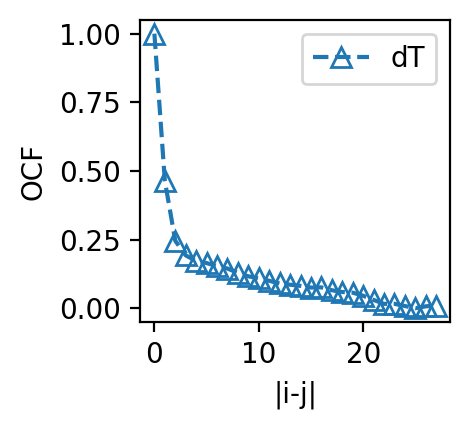

In [22]:
fig,ax = plt.subplots(figsize=(2, 2),dpi=200)

dx=x[3]-x[2];
ax.plot((x/dx),results,'^--',label='dT',markersize=7,markerfacecolor='none',color='tab:blue')

ax.set_xlabel("|i-j|")
ax.set_ylabel("OCF")

plt.legend()